In [1]:
from ola_RNN import * 
from ola_trump import *
from ola_dataloader import * 

import os, time, copy, math, re, json, pickle, random
import numpy as np
import pandas as pd

import torch, torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker

from functools import partial 

cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_available else "cpu")
print(f'''using device {device}''')

path = !pwd
path = path[0]
print(path)

using device cuda:0
/home/r2/Documents/RNNexp


In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

In [3]:
class Learner():
    def __init__(self, model, loss_fn, opt, data, lr):
        self.model, self.opt, self.loss_fn, self.data = model, opt, loss_fn, data
        self._lr     = opt.param_groups[0]['lr']
        
    @property
    def lr(self):
        return self._lr
    
    @lr.setter
    def lr(self,lr):
        self._lr = lr
        for param_group in self.opt.param_groups:
            param_group['lr'] = lr        

In [158]:


class RNN2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN2,self).__init__()
        self.hd_sz  = hidden_size
        self.in_sz  = input_size
        self.out_sz = output_size
        
        combined = input_size+hidden_size
        
        self.h1      = nn.Linear(combined, hidden_size)               

        self.o1      = nn.Linear(combined, combined)
        self.relu    = nn.ReLU(combined)

        self.o2      = nn.Linear(combined, combined)
        self.relu2   = nn.ReLU(combined)
        
        self.o3      = nn.Linear(combined, input_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)    
        
        hidden   = self.h1(combined)
        hidden   = torch.tanh(hidden)
        
        output   = self.o1(combined)
        output   = self.relu(output)
        
        output   = self.o2(output)
        output   = self.relu2(output)
        
        output   = self.o3(output)
        output   = self.softmax(output)
        return output, hidden

    def initHidden(self,bs):
        return cuda(torch.zeros(bs,self.hd_sz))

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN,self).__init__()
        self.hd_sz  = hidden_size
        self.in_sz  = input_size
        self.out_sz = output_size
        
        combined = input_size+hidden_size
        
        self.h1      = nn.Linear(combined, hidden_size)               

        self.o1      = nn.Linear(combined, combined)
        self.relu    = nn.ReLU(combined)

        self.o2      = nn.Linear(combined, input_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)    
        
        hidden   = self.h1(combined)
        hidden   = torch.tanh(hidden)
        
        output   = self.o1(combined)
        output   = self.relu(output)
        
        output   = self.o2(output)
        output   = self.softmax(output)
        return output, hidden

    def initHidden(self,bs):
        return cuda(torch.zeros(bs,self.hd_sz))    
    
class RNN41(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN41,self).__init__()
        self.hd_sz  = hidden_size
        self.in_sz  = input_size
        self.out_sz = output_size
        
        combined = input_size+hidden_size
        
        self.h1      = nn.Linear(combined, hidden_size)  

        self.o1      = nn.Linear(combined, combined)
        self.relu    = nn.ReLU(combined)

        self.o2      = nn.Linear(combined, combined)
        self.relu2   = nn.ReLU(combined)
        
        self.o3      = nn.Linear(combined, combined)
        self.relu3   = nn.ReLU(combined)
        
        self.o4      = nn.Linear(combined, combined)
        self.relu4   = nn.Linear(combined, combined)
        
        self.o5      = nn.Linear(combined, input_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)    
        
        hidden   = self.h1(combined)
        hidden   = torch.tanh(hidden)
        
        output   = self.o1(combined)
        output   = self.relu(output)
        
        output   = self.o2(output)
        output   = self.relu2(output)
        
        output   = self.o3(output)
        output   = self.relu3(output)
        
        output   = self.o4(output)
        output   = self.relu4(output)
        
        output   = self.o5(output)
        output   = self.softmax(output)
        return output, hidden

    def initHidden(self,bs):
        return cuda(torch.zeros(bs,self.hd_sz))        
    
class RNN42(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN42,self).__init__()
        self.hd_sz  = hidden_size
        self.in_sz  = input_size
        self.out_sz = output_size
        
        combined = input_size+hidden_size
        
        self.h1      = nn.Linear(combined, combined)  
        self.h1relu  = nn.ReLU(combined)
        
        self.h2      = nn.Linear(combined, hidden_size)

        self.o1      = nn.Linear(combined, combined)
        self.relu    = nn.ReLU(combined)

        self.o2      = nn.Linear(combined, combined)
        self.relu2   = nn.ReLU(combined)
        
        self.o3      = nn.Linear(combined, combined)
        self.relu3   = nn.ReLU(combined)
        
        self.o4      = nn.Linear(combined, combined)
        self.relu4   = nn.Linear(combined, combined)
        
        self.o5      = nn.Linear(combined, input_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)    
        
        hidden   = self.h1(combined)
        hidden   = self.h1relu(hidden)

        hidden   = self.h2(hidden)        
        hidden   = torch.tanh(hidden)
        
        output   = self.o1(combined)
        output   = self.relu(output)
        
        output   = self.o2(output)
        output   = self.relu2(output)
        
        output   = self.o3(output)
        output   = self.relu3(output)
        
        output   = self.o4(output)
        output   = self.relu4(output)
        
        output   = self.o5(output)
        output   = self.softmax(output)
        return output, hidden

    def initHidden(self,bs):
        return cuda(torch.zeros(bs,self.hd_sz))    

In [159]:
def fit_rnn(learn, epoches, valid_loss=[], itters=math.inf, cb=None):
    hidden = learn.model.initHidden(15)    
    for epoch in range(epoches):
        for xb, yb in iter(learn.data.train_dl):   
            learn.model.train()
            output, hidden, loss = rnn_forward(learn,hidden,xb,yb)
            if loss != 0:
                loss.backward()
                learn.opt.step()
                learn.opt.zero_grad()
            if (learn.data.train_dl.nb_itters()%100==0): valid_loss.append(get_valid_rnn(learn,itters=30))  
            if learn.data.train_dl.nb_itters() == itters: 
                print("breaking")
                break
        print(f"""finished epoch {epoch}""")
    return learn, hidden, valid_loss

def rnn_forward(learn,hidden,xb,yb):
    learn.model.train()
    if xb[0,0,1].item() == 1: hidden = learn.model.initHidden(xb.shape[0])                   
    loss = 0 
    for char in range(xb.shape[1]):
        x,y = xb[:,char],yb[:,char]
        x,y,hidden = unpad_rnn(x,y,hidden)

        if x is None: break        
        output,hidden = learn.model.forward(x,hidden)
        loss += learn.loss_fn(output,y)                

    if loss == 0: return None,hidden.detach(),loss 
    return output,hidden.detach(),loss/(char+1)

def unpad_rnn(x,y,hidden):
    idx = (y != 0).nonzero()
    if idx.shape[0] < 2: return None,y,hidden
    else: idx = idx.squeeze()
    return x[idx],y[idx],hidden[idx]

def get_valid_rnn(learn,itters=30):
#     print(f"""getting validation""")    
    learn.model.eval()
    tot_loss = 0 
    with torch.no_grad():
        hidden = learn.model.initHidden(15)
        for xb,yb in iter(learn.data.valid_dl): 
            output, hidden, loss = rnn_forward(learn,hidden,xb,yb)  
            if loss != 0: tot_loss += loss.item()/xb.shape[0]
            if learn.data.valid_dl.nb_itters() == itters: 
                return tot_loss/learn.data.valid_dl.nb_itters()
        
    return tot_loss/learn.data.valid_dl.nb_itters()


def generate_seq(model,Data,sql,symbol='^'):
    model.eval()
    with torch.no_grad():
        hidden = model.initHidden(1)
        result = symbol
        for i in range(sql):
            x = cuda(onehencode(symbol,Data.encoder))
            output, hidden = model.forward(x,hidden)        
            hidden = hidden.detach()
            
            prob     = np.exp(output[0].cpu().numpy())
            cum_prob = np.cumsum(prob)
            idx      = np.where(cum_prob - random.random() > 0)[0][0]
            symbol   = Data.decoder[idx]
            result  += symbol
    model.train()
    print(result)

In [168]:
bs  = 20
sql = 30 
lr  = 0.0005 

data          = pp_trumpdata(path+"/data/trump/", [0.9,0.95], bs)
data.train_dl = TweetDataLoader(data,data.train.tweets,bs,sql,shuffle=True)
data.valid_dl = TweetDataLoader(data,data.valid.tweets,bs,sql,shuffle=False)

model  = cuda(RNN42(len(data.decoder), 150, 1))
opt    = optim.RMSprop(model.parameters(), lr)

model2 = cuda(RNN42(len(data.decoder), 150, 1))
opt2   = optim.RMSprop(model2.parameters(), lr)

learn  = Learner(model,  nn.NLLLoss(), opt , data, lr=lr)
learn2 = Learner(model2, nn.NLLLoss(), opt2, data, lr=lr)

In [382]:
learn.lr = 0.00005

In [393]:
start = time.time()
learn, hidden, valid_loss   = fit_rnn(learn,3,valid_loss=valid_loss)
print(f"""finished first took {time.time() - start} seconds""")
# learn2, hidden, valid_loss2 = fit_rnn(learn2,1,valid_loss=[])
# print(f"""finished second took {time.time() - start} seconds""")

finished epoch 0
finished epoch 1
finished epoch 2
finished first took 1004.9092297554016 seconds


In [394]:
print(len(valid_loss),len(valid_loss2))

4004 378


0.07384479721387227 0.0804778573910395


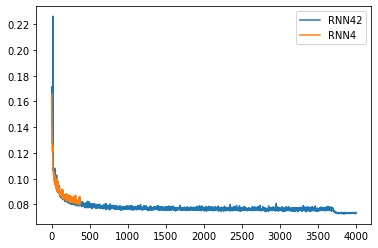

In [395]:
plt.figure()
plt.plot([x for x in range(len(valid_loss))],valid_loss,label='RNN42')
plt.plot([x for x in range(len(valid_loss2))],valid_loss2,label='RNN4')       
plt.legend()                                                               

print(valid_loss[-1],valid_loss2[-1])

In [386]:
learn.loss_fn.reduction

'mean'

In [387]:
def movingavg(values,window):
    weights = np.repeat(1.0,window)
    smas = np.convolve(values,weights,'valid')/window
    return smas

In [388]:
print(min(valid_loss2),min(valid_loss[2400:-1]))

0.07975301265716551 0.0728580250342687


In [389]:
emadb = []
ema   = [] 
avg = None
for i in range(len(valid_loss)):    
    avg, res = mom3(avg,valid_loss[i],0.9,i)
    ema.append(avg)
    emadb.append(res)
    
ema = ema[10:-1]
emadb = emadb[10:-1]

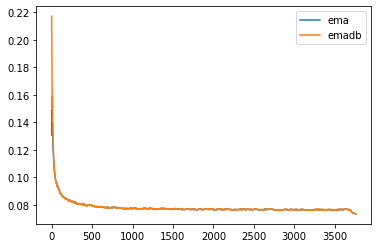

In [390]:
plt.figure()
plt.plot([x for x in range(len(ema))],ema,label='ema')
plt.plot([x for x in range(len(emadb))],emadb,label='emadb')       
plt.legend()                                                               

In [391]:
def ewma(v1, v2, beta): 
    """exponential weighted moving average / lerp"""
    """torch.lerp(v2, v1, beta) other way around!"""    
    return beta*v1 + (1-beta)*v2

def mom_db(avg, yi, beta, i):
    if avg is None: avg=yi
    res = ewma(avg,yi,beta)
    return res, res/(1-beta**(i+1))

    

In [392]:
generate_seq(learn.model,learn.data,500)

^As usual! Republicans begin. Polls!€"€ from the haters!€He even $1zation to be saved me our country.€!"€ apologize” stupid policy Jobs create. We need to climbable votes, but now countries, but it was the only one info.€"€! all of my wonderful future of every way it was out!€Gun air after interviews. https://t.co/3Iq1JnkpIi€i- from the @FoxNews Thank you for your country is going to blame it dirty action of Trump..”  @x.Bowler Internet safe! #MAGA€johnheadrin with HealthCare Performance. Nothing


In [154]:
generate_seq(learn2.model,learn.data,500)

^When The First OrX. We aren’t year on the braves!€ the problem gys innessears why (big milf-gun. They couldn’t go get in better.€ne!€.€64?8d. #Trump2016
MIBH! negulation one! For the people than he do shody for them correct. 
#Manwanty @party- @scantonEforal Surplusion Appeals let the man fool. I suppen and John Kelly Russia, otherm Trump aball HAUCH SER."€ Congress to wins energy #John Kerous control People on defend. The!€. We are I gulation! Also, and brings who has use their shet!€€ Servers,
